### Vegetation sensitivity

partioning/aggregating data to see if this provides more robust measures, using consecutive counts to meet FAO veg/non veg

use `time.month` or `time.day` or `time.week` or `time.dayofyear`
- monthly (consecutive = 2)
- fortnightly (consecutive = 4)
- weekly (consecutive = 8)

https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Frequently_used_code/Virtual_products.ipynb
http://xarray.pydata.org/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html
https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/Frequently_used_code/Working_with_time.ipynb

In [60]:
import os, sys
import xarray as xr
import numpy as np
import pandas
from matplotlib import pyplot as plt

import datacube
from datacube.storage import masking
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
pandas.set_option('display.max_colwidth', 200)
pandas.set_option('display.max_rows', None)
dc = datacube.Datacube(app="veg_sensitivity")

from numba import jit

In [72]:
# # 13, -28 (Central west QLD, 2010 veg, 2015 bare)
# x = (1300000, 1350000)
# y = (-2750000, -2700000)

# # 13, -28 (Central west QLD, 2010 veg, 2015 bare) not square
# x = (1300000, 1325000)
# y = (-2750000, -2700000)

# # 1, -25 (Central NT, 2010 veg, 2015 bare)
# x = (150000, 200000)
# y = (-2450000, -2500000)

# # 16, -40 (Nowra, 2010 veg, 2015 veg)
# x = (1650000, 1700000)
# y = (-3900000, -3950000)

# -4, -22 (West SA, 2010 bare, 2015 bare - only slight change in veg)
x = (-400000, -350000)
y = (-3100000, -3150000)

# # 11, -48 (Southwest Tassie, 2010 veg 2015, bare 2015 - should be all veg/water, problem with obs count)
# x = (1150000, 1200000)
# y = (-4700000, -4750000)

res = (-100, 100)
crs = "EPSG:3577"
time = ("2015-01-01", "2015-12-31")

query =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'resolution':res})

# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/r78/LCCS_Aberystwyth/co6850/'

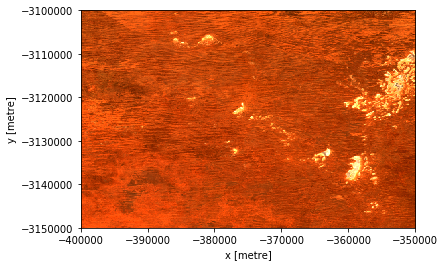

In [73]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

#### create the same virtual product as vegetat_veg_cat

In [74]:
sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
sys.path.append(str(service)+"dea-notebooks/Scripts")
sys.path.append(str(service)+"livingearth_australia")

os.environ["LE_LCCS_PLUGINS_PATH"] = str(service)+"livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs.le_ingest import gridded_ingest
from le_lccs import le_export
from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4

# datacube functions to load in a virtual product from recipe
from datacube.virtual import catalog_from_file
catalog = catalog_from_file(str(service)+'livingearth_australia/le_plugins/virtual_product_cat_veg_testing.yaml')

In [75]:
# load from datacube virtual product
# product = catalog['vegetat_veg_cat']
# can remove ls7 if not wanted
product = catalog['vegetat_veg_cat_ls7removed']
data = product.load(dc, **query)
data

<xarray.Dataset>
Dimensions:  (time: 43, x: 500, y: 500)
Coordinates:
  * x        (x) float64 -4e+05 -3.998e+05 -3.998e+05 ... -3.502e+05 -3.500e+05
  * y        (y) float64 -3.1e+06 -3.1e+06 -3.1e+06 ... -3.15e+06 -3.15e+06
  * time     (time) datetime64[ns] 2015-01-04T01:19:56 ... 2015-12-30T01:21:31
Data variables:
    BS       (time, y, x) int16 48 54 56 52 51 52 52 50 ... 49 48 48 45 45 43 45
    PV       (time, y, x) int16 13 12 12 12 13 13 13 14 ... 12 12 12 13 14 15 14
    NPV      (time, y, x) int16 38 33 31 35 36 34 34 35 ... 38 39 39 41 40 41 41
    water    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:3577

#### function to get consecutive counts for each pixel
- note `required_consecutive` will depend on time interval used to allign with FAO definition (i.e. fortnight = 4)

In [76]:
def consecutive_count(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series
    
    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''
    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # num_consecutive set to 1 as if statement below requires looking at previous value
            # therefore cannot use required_consecutive=1, however not a problem
            # as we wouldn't want to know anything >=2 for required_consecutive
            num_consecutive = 1
            max_num_consecutive = 0
            # Go through all dates looking for consecutive values
            for z in range(1, tv_numpy.shape[0]):
                # If value is the same as previous date and same as consec_msk_val
                # iterate number of consecutive
                if (tv_numpy[z-1,y,x] == tv_numpy[z,y,x]) and (tv_numpy[z,y,x] == consec_msk_val):
                    num_consecutive += 1
                    if num_consecutive > max_num_consecutive:
                        max_num_consecutive = num_consecutive
                # If not reset counter
                else:
                    num_consecutive = 1
            # If there enough consecutive 1's for required_consecutive
            # Set output to veg (1)
            if max_num_consecutive >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                 consecutive_numpy[y,x] = 0
    return consecutive_numpy

#### monthly aggregation


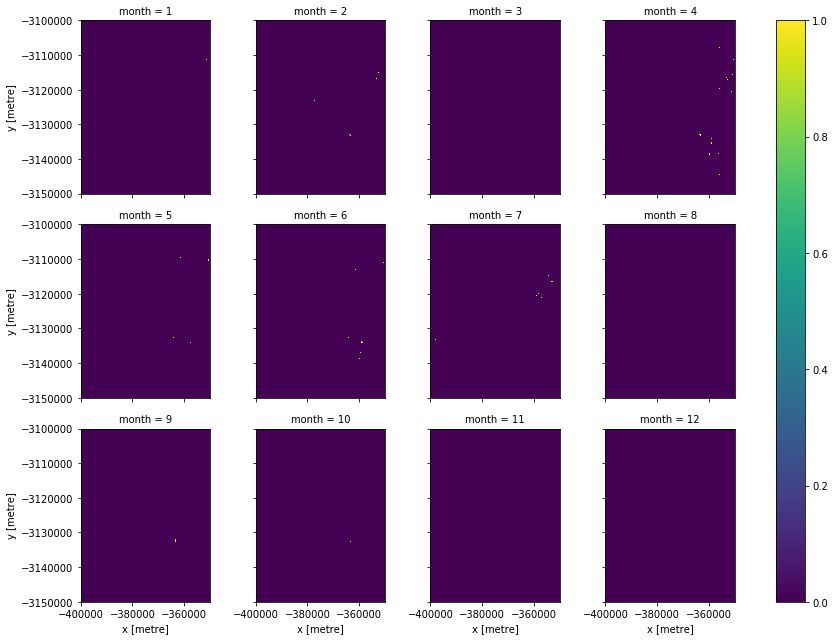

In [77]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_month = data_mask.groupby('time.month').median(dim='time')

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_month['BS'] < data_month['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water'] != 128), 0)
tv = tv_mask.where((data_month['water'] != 132), 0)
tv.plot(col='month', col_wrap=4)

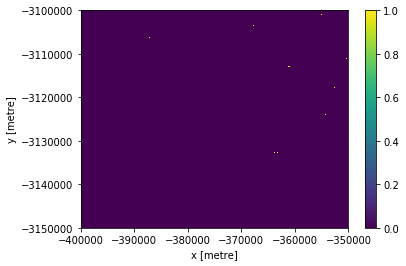

In [78]:
# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv.values

# Set up array for output (faster to pre-allocate for numba)
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.uint8)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using median here but not important as we just want to use shape/attributes
tv_reduce = tv.median(dim='month')

# create new data array with sampe dimensions as original
tv_summary = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)

tv_summary.plot()

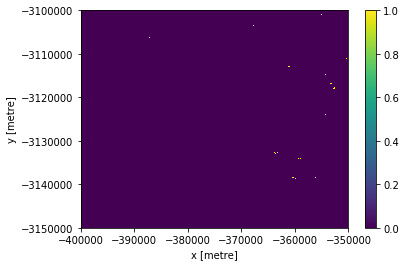

In [79]:
# not using consectutive for comparison #
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='month')

# Create a boolean layer where vegetation is assigned if greater than 4 fortnights
tv_summary_filt = (tv_summary >= 2).where(tv_summary.notnull())
tv_summary_filt.plot()

#### fortnightly aggregation 

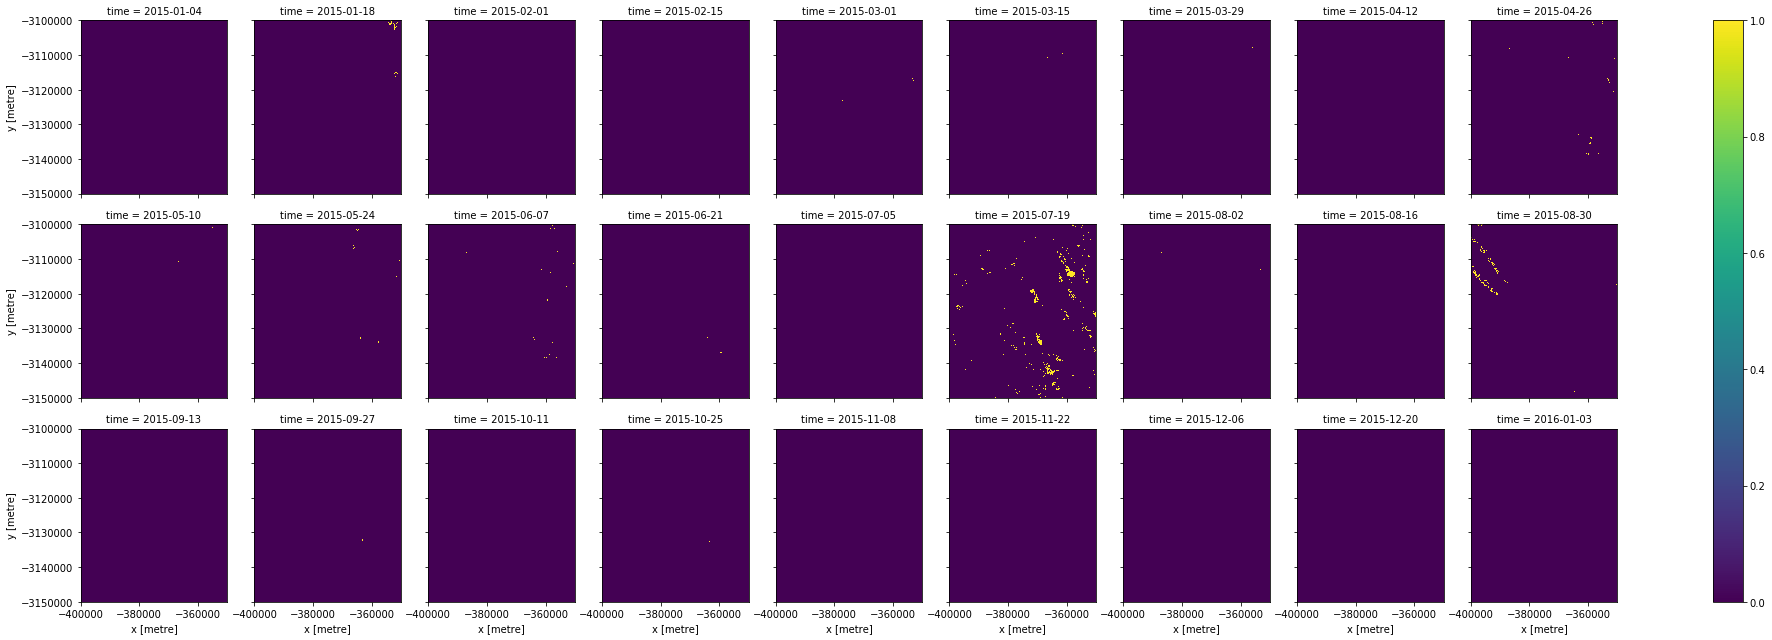

In [80]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_fn = data_mask.resample(time='2w').median()

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_fn['BS'] < data_fn['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_fn['water'] != 128), 0)
tv = tv_mask.where((data_fn['water'] != 132), 0)
tv.plot(col='time', col_wrap=9)

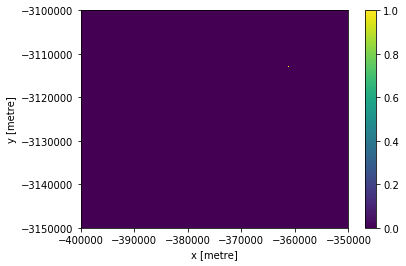

In [81]:
# executing consecutive_count function #
# veg = 4 consecutive fortnights
required_consecutive = 4

# Pull tv as numpy array
tv_numpy = tv.values

# Set up array for output (faster to pre-allocate for numba)
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.uint8)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using median here but not important as we just want to use shape/attributes
tv_reduce = tv.median(dim='time')

# create new data array with sampe dimensions as original
tv_summary = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)

tv_summary.plot()

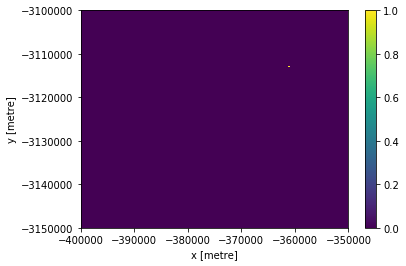

In [82]:
# not using consectutive for comparison #
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='time')

# Create a boolean layer where vegetation is assigned if greater than 4 fortnights
tv_summary_filt = (tv_summary >= 4).where(tv_summary.notnull())
tv_summary_filt.plot()

#### weekly aggregation 
- not enough data for this

In [ ]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_week = data_mask.groupby('time.week').median(dim='time')

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_week['BS'] < data_week['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_week['water'] != 128), 0)
tv = tv_mask.where((data_week['water'] != 132), 0)
tv.plot(col='week', col_wrap=7)

In [ ]:
# executing consecutive_count function #
# veg = 8 consecutive weeks
required_consecutive = 4

# Pull tv as numpy array
tv_numpy = tv.values

# Set up array for output (faster to pre-allocate for numba)
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.uint8)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using median here but not important as we just want to use shape/attributes
tv_reduce = tv.median(dim='week')

# create new data array with sampe dimensions as original
tv_summary = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)

tv_summary.plot()

In [ ]:
# not using consectutive for comparison #
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='week')

# Create a boolean layer where vegetation is assigned if greater than 8 weeks
tv_summary_filt = (tv_summary >= 8).where(tv_summary.notnull())
tv_summary_filt.plot()

#### seasonal aggregation
- not useful, over-aggregation

In [ ]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_season = data_mask.groupby('time.season').min(dim='time')

# # run pluging rules #
# # Create mask where BS < PV
tv_mask = data_season['BS'] < data_season['PV']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_season['water'] != 128), 0)
tv = tv_mask.where((data_season['water'] != 132), 0)
# tv.plot(col='season', col_wrap=2)

In [ ]:
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='season')

# Create a boolean layer where vegetation is assigned if greater than 6 months
tv_summary_filt = (tv_summary > 1).where(tv_summary.notnull())
# tv_summary_filt.plot()

#### PV min, BS max monthly - WIP
- results similar to both median

In [ ]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0))
data_month_water = data_mask.water.groupby('time.month').median(dim='time')
data_month_BS = data_mask.BS.groupby('time.month').max(dim='time')
data_month_PV = data_mask.PV.groupby('time.month').min(dim='time')

# add these datasets as variables
data_month_water_ds = data_month_water.to_dataset(name="water_month_median")
data_month_BS_ds = data_month_BS.to_dataset(name="BS_month_max")
data_month_PV_ds = data_month_PV.to_dataset(name="PV_month_min")
# merge back together
variables_xarray_list = []
variables_xarray_list.append(data_month_water_ds)
variables_xarray_list.append(data_month_BS_ds)
variables_xarray_list.append(data_month_PV_ds)
data_month = xr.merge(variables_xarray_list)
data_month

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_month['BS_month_max'] < data_month['PV_month_min']

# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water_month_median'] != 128), 0)
tv = tv_mask.where((data_month['water_month_median'] != 132), 0)
# tv.plot(col='month', col_wrap=4)

In [ ]:
# Calculate the proportion of the year vegetation is greater than the bare soil fraction of a pixel
tv_summary = tv.sum(dim='month')

# Create a boolean layer where vegetation is assigned if greater than 2months
tv_summary_filt = (tv_summary > 2).where(tv_summary.notnull())
# tv_summary_filt.plot()

#### Integrating NPV to monthly - WIP
- NPV is reasonably confused with BS in areas that we are having issue with, so this is particularly worth spending time on at the moment

In [ ]:
# masking out no data areas before groupby so that no data is not considered for median function
data_mask = data.where((data['BS'] > 0) & (data['PV'] > 0) & (data['NPV'] > 0))
data_month = data_mask.groupby('time.month').median(dim='time')
data_month

# run pluging rules #
# Create mask where BS < PV
tv_mask = data_month['BS'] < data_month['PV']
# Create mask where BS < NPV
tv_mask = data_month['BS'] < data_month['PV']


In [ ]:


# Can't trust FC where there is water
# Mask where clear water was observed in WOfS (128: clear and wet, 132: clear, wet & sea)
tv = tv_mask.where((data_month['water'] != 128), 0)
tv = tv_mask.where((data_month['water'] != 132), 0)
# tv.plot(col='month', col_wrap=4)